# Inteligencia Artificial

# Clase 16 - Deep Learning para datos secuenciales

## Clasificación de secuencias

En esta notebook trabajaremos con redes recurrentes para clasificar movimientos humanos. Esta tarea se la conoce como _Human Activity Recognition_ y el objetivo de la misma es poder predecir qué acción está realizando una persona en función de diversos datos de entrada. Dejando de lado la fuente, siempre estamos hablando de acciones dinámicas que la persona realiza en un período de tiempo, como caminar, sentarse, pararse, etc.<br>
Existen varias formas de encarar este problema y depende de qué recursos se quieran utilizar. Un enfoque posible es tomar un video de la persona realizando la acción y procesarlo en crudo o extraer features sobre la posición de la persona en cada frame utilizando algún sistema como [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) y procesando luego las features extraídas.<br>
En este ejemplo trabajaremos con datos crudos de un smartphone que lleva la persona realizando la acción. En el siguiente video se muestra el setup del experimento y la recolección de datos:

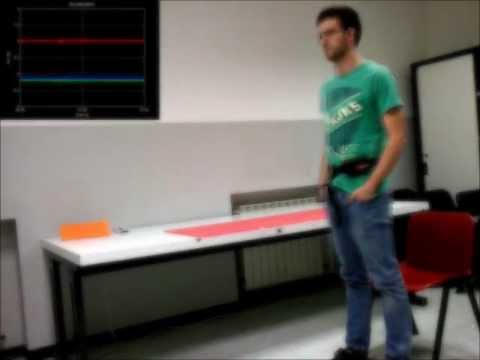

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('XOEN9W05_4A')

Se registraron movimientos de 30 personas de entre 19 y 48 años realizando 6 acciones distintas:
- Caminando
- Subiendo escaleras
- Bajando escaleras
- Parándose
- Sentándose
- Acostándose

Para registrar los movimientos se utilizaron los sensores de un Samsung Galaxy SII que los participantes llevaban en la cintura, como muestra el video. Esto produjo 6 señales de salida:
- 3 ejes del acelerómetro
- 3 ejes del giróscopo

Las señales del acelerómetro fueron procesadas para separar las componentes gravitacionales y las componentes humanas del movimiento, produciendo así 3 salidas nuevas totalizando 9 señales. Más información sobre el experimento puede ser encontrada en su [repositorio oficial](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

Otro preprocesamiento que es importante mencionar es que se dividieron las señales en ventanas de 128 muestras, haciendo que cada ventana dure 2.56 segundos (dada la frecuencia de muestreo de 50Hz)

### Benchmark
Se hizo feature engineering para extraer propiedades temporales y frecuenciales de cada ventana, relevantes en el estudio de los movimientos humanos, obteniendo así un dataset tabular de 561 features que se usó para entrenar un clasificador SVM obteniendo una accuracy del 89% en el set de testeo.

En esta notebook intentaremos procesar las señales en crudas para realizar la misma tarea y evaluar el desempeño de redes LSTM para la clasificación de secuencias. Esta notebook está basada en el siguiente [post](https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/).

### El dataset

Comenzaremos cargando el dataset.

El mismo ya se encuentra dividido en train (70%) y test (30%) y dentro de la carpeta `Inertial Signals` encontraremos los 9 archivos correspondientes a las 9 señales que debemos procesar.

In [2]:
import pandas as pd
import numpy as np
import os

Cargamos cada archivo por separado

In [3]:
data = []
filename = ['body_acc_{}_train.txt', 'body_gyro_{}_train.txt', 'total_acc_{}_train.txt']
axis = ['x', 'y', 'z']
path = 'UCI HAR Dataset'
for f in filename:
    for a in axis:
        full_path = os.path.join(path, 'train', 'Inertial Signals', f.format(a))
        data.append(pd.read_csv(full_path, header=None, delim_whitespace=True).values)

In [4]:
len(data)

9

Cada archivo cargado contiene los valores de una señal durante las 128 muestras (_timesteps_) de la ventana.

In [5]:
data[0].shape

(7352, 128)

Recordemos que debemos llevar el dataset a la forma (m_muestras, timesteps, n_features).

<img width=400px src=https://www.tensorflow.org/tutorials/structured_data/images/time_series.png>

Para eso apilaremos todos los datos en un único tensor (`ndarray`) y luego manipularemos las dimensiones

In [6]:
X_train = np.stack(data)

In [7]:
X_train.shape

(9, 7352, 128)

In [8]:
X_train = X_train.transpose(1,2,0)
X_train.shape

(7352, 128, 9)

Analicemos la primer observación

In [9]:
X_train[0].shape

(128, 9)

Tenemos los 128 valores de las 9 señales a lo largo del tiempo. Si queremos ver una "foto" de la secuencia:

In [10]:
X_train[0][0]

array([ 1.808515e-04,  1.076681e-02,  5.556068e-02,  3.019122e-02,
        6.601362e-02,  2.285864e-02,  1.012817e+00, -1.232167e-01,
        1.029341e-01])

Si queremos analizar la evolución de cada señal a lo largo del tiempo:

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

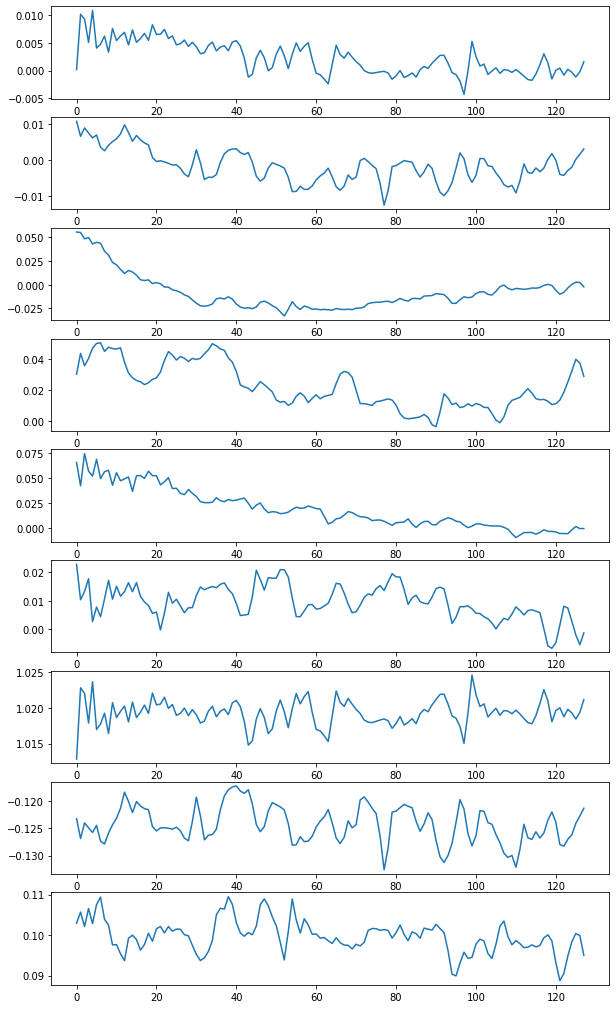

In [12]:
fig, ax = plt.subplots(9,1, figsize=(10, 18))
for i in range(9):
    ax[i].plot(X_train[0,:,i])

Observamos que los datos no están normalizados

In [13]:
X_train.max(axis=(0,1))

array([1.299912 , 0.9759764, 1.066916 , 4.155473 , 5.746062 , 2.365982 ,
       2.197618 , 1.21735  , 1.281363 ])

In [14]:
X_train.min(axis=(0,1))

array([-1.232238 , -1.345267 , -1.364707 , -4.733656 , -5.97433  ,
       -2.763014 , -0.4665558, -1.582079 , -1.639609 ])

Hacemos normalización Min-Max guardando los valores utilizados para replicar el proceso sobre el set de testeo. Recordemos que la normalización se debe realizar a nivel de features. Luego reescalaremos los datos para llevarlos al rango [-1,1]

In [15]:
X_max = X_train.max(axis=(0,1))
X_min = X_train.min(axis=(0,1))
X_train = (X_train - X_min) / (X_max - X_min)

In [16]:
X_train = X_train * 2 - 1

In [17]:
X_train.max(axis=(0,1))

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
X_train.min(axis=(0,1))

array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])

Procedamos a cargar las etiquetas que le corresponden a cada secuencia

In [19]:
y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, delim_whitespace=True)
y_train

,0
0,5
1,5
2,5
3,5
4,5
...,...
7347,2
7348,2
7349,2
7350,2


In [20]:
y_train.shape

(7352, 1)

Tenemos una sola etiqueta para cada secuencia. Analicemos el balance de clases:

In [21]:
y_train[0].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: 0, dtype: int64

Como estan (casi) igualmente representadas, seguiremos con el pre procesamiento. 

Recordemos que al tratarse de un problema de clasificación multiclase, la capa de salida de la red tendrá tantas neuronas como clases disponibles (6) y por lo tanto debemos codificar los valores en vectores one-hot. Para eso usaremos la función `keras.utils.to_categorical`.

In [22]:
# Pasamos las etiquetas a valores del 0 al 5
y_train = y_train - 1

In [23]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [24]:
y_train_cat = to_categorical(y_train.values)

In [25]:
y_train_cat.shape

(7352, 6)

In [26]:
y_train_cat

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

### El modelo 

Ahora procederemos a armar el modelo utilizando la API secuencial de Keras. Para eso importaremos la clase `Sequential`, `GRU`, `LSTM` y `Dense`.

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

In [28]:
model = Sequential()
model.add(GRU(100, input_shape=(128, 9)))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               33000     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 33,606
Trainable params: 33,606
Non-trainable params: 0
_________________________________________________________________


Como es un problema de clasificación multiclase, utilizaremos la categorical crossentropy como función de pérdida. Optimizaremos con Adam monitoreando la accuracy.

In [29]:
model.compile('rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [30]:
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=30, validation_split=0.15, shuffle=True)

Train on 6249 samples, validate on 1103 samples
Epoch 1/30
6249/6249 [==============================] - 4s 644us/step - loss: 1.3521 - acc: 0.4081 - val_loss: 1.2244 - val_acc: 0.5068
Epoch 2/30
6249/6249 [==============================] - 4s 613us/step - loss: 1.0497 - acc: 0.5362 - val_loss: 1.2186 - val_acc: 0.5530
Epoch 3/30
6249/6249 [==============================] - 4s 560us/step - loss: 1.0095 - acc: 0.5657 - val_loss: 1.1770 - val_acc: 0.5014
Epoch 4/30
6249/6249 [==============================] - 3s 547us/step - loss: 0.9748 - acc: 0.5739 - val_loss: 1.0779 - val_acc: 0.5195
Epoch 5/30
6249/6249 [==============================] - 3s 552us/step - loss: 0.9184 - acc: 0.6030 - val_loss: 1.1878 - val_acc: 0.4370
Epoch 6/30
6249/6249 [==============================] - 4s 591us/step - loss: 0.8930 - acc: 0.6195 - val_loss: 0.9723 - val_acc: 0.5875
Epoch 7/30
6249/6249 [==============================] - 4s 605us/step - loss: 0.8054 - acc: 0.6907 - val_loss: 0.9404 - val_acc: 0.5839


Definimos una función para graficar la evolución del entrenamiento

In [31]:
def plot_history(history, metric):
    fig, ax = plt.subplots(1,2,figsize=(18,6))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[1].plot(history.history[metric])
    ax[1].plot(history.history['val_{}'.format(metric)])
    ax[1].set_title(metric)
    fig.legend(['Train', 'Val'])

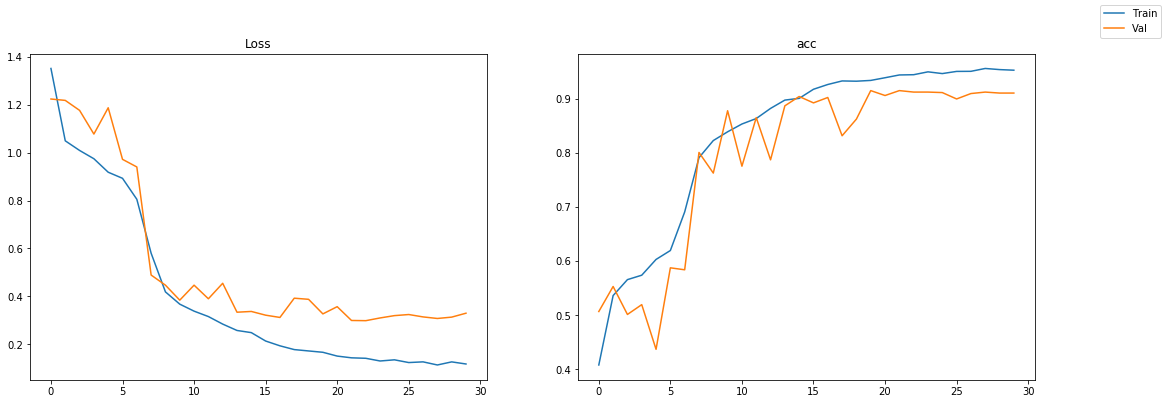

In [32]:
plot_history(history, 'acc')

Observamos que el modelo es capaz de aprender de las secuencias de datos e incluso vemos señales de overfitting.

Analicemos los resultados sobre el set de entrenamiento.

In [33]:
pred = model.predict(X_train)

Recordemos que la salida del modelo es una función softmax entre las 6 unidades de la última capa densa. 

In [34]:
pred.shape

(7352, 6)

In [35]:
pred[0]

array([2.9768706e-03, 3.5403640e-04, 3.3050688e-04, 5.6318406e-02,
       9.3992114e-01, 9.9103469e-05], dtype=float32)

Debemos quedarnos con el índice del mayor valor

In [36]:
pred_labels = pred.argmax(axis=1)

In [37]:
pred_labels.shape

(7352,)

Cargamos las referencias de qué indica cada actividad

In [38]:
label_reference = pd.read_csv('UCI HAR Dataset/activity_labels.txt', header=None, delim_whitespace=True, names=['code', 'activity'])
label_reference.set_index('code', inplace=True)

In [39]:
label_reference

,activity
code,
1,WALKING
2,WALKING_UPSTAIRS
3,WALKING_DOWNSTAIRS
4,SITTING
5,STANDING
6,LAYING


Graficamos la matriz de confusión

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

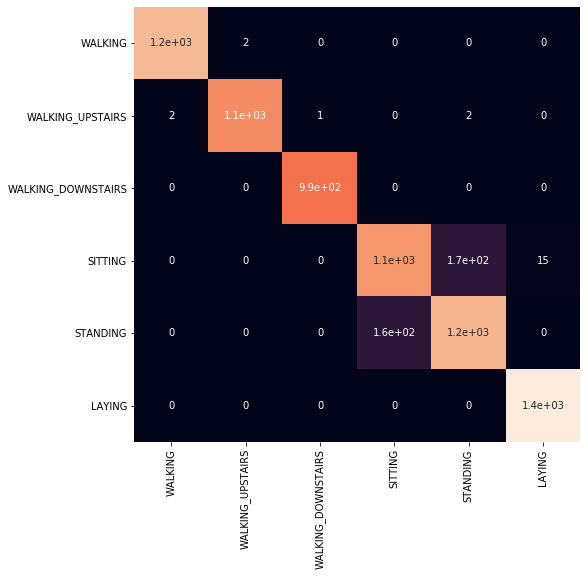

In [41]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_train, pred_labels), annot=True, cbar=False, xticklabels=label_reference['activity'], yticklabels=label_reference['activity'])

Se observan clases perfectamente definidas mientras que SITTING y STANDING parecen confundirse entre sí.

Probemos ahora con la misma red, pero reemplazando las celdas GRU por las LSTM.

In [42]:
model = Sequential()
model.add(LSTM(100, input_shape=(128, 9)))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 44,606
Trainable params: 44,606
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile('rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [44]:
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=30, validation_split=0.15, shuffle=True)

Train on 6249 samples, validate on 1103 samples
Epoch 1/30
6249/6249 [==============================] - 3s 494us/step - loss: 1.2987 - acc: 0.4476 - val_loss: 1.1634 - val_acc: 0.5240
Epoch 2/30
6249/6249 [==============================] - 3s 451us/step - loss: 1.1348 - acc: 0.5111 - val_loss: 1.2020 - val_acc: 0.4597
Epoch 3/30
6249/6249 [==============================] - 3s 463us/step - loss: 1.0568 - acc: 0.5380 - val_loss: 1.1487 - val_acc: 0.4841
Epoch 4/30
6249/6249 [==============================] - 3s 457us/step - loss: 1.0128 - acc: 0.5606 - val_loss: 1.1413 - val_acc: 0.5612
Epoch 5/30
6249/6249 [==============================] - 3s 456us/step - loss: 0.9943 - acc: 0.5675 - val_loss: 1.1139 - val_acc: 0.5159
Epoch 6/30
6249/6249 [==============================] - 3s 455us/step - loss: 0.9404 - acc: 0.6025 - val_loss: 0.9823 - val_acc: 0.6392
Epoch 7/30
6249/6249 [==============================] - 3s 452us/step - loss: 0.7160 - acc: 0.7355 - val_loss: 0.7602 - val_acc: 0.7117


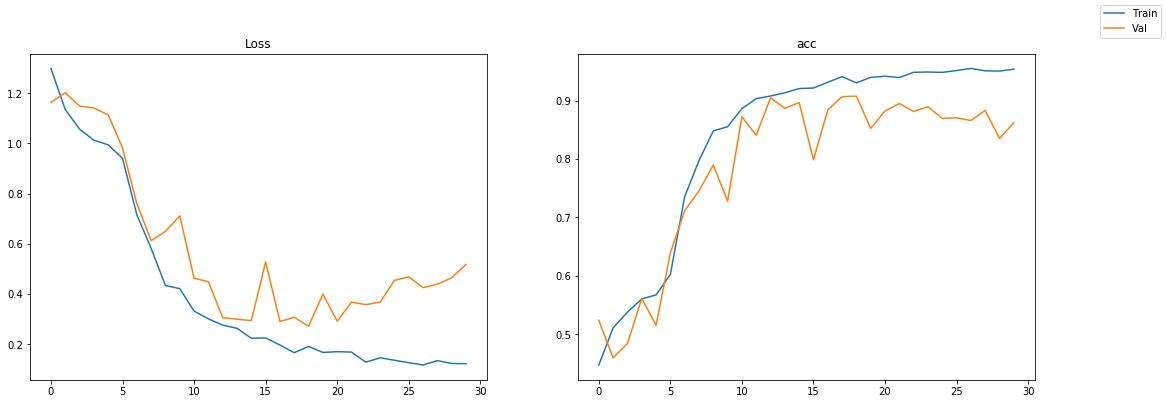

In [45]:
plot_history(history, 'acc')

Obtuvimos resultados similares en cuanto a performance. Veamos qué ocurrió con la matriz de confusión.

In [46]:
pred = model.predict(X_train)

In [47]:
pred_labels = pred.argmax(axis=1)

In [48]:
pred_labels.shape

(7352,)

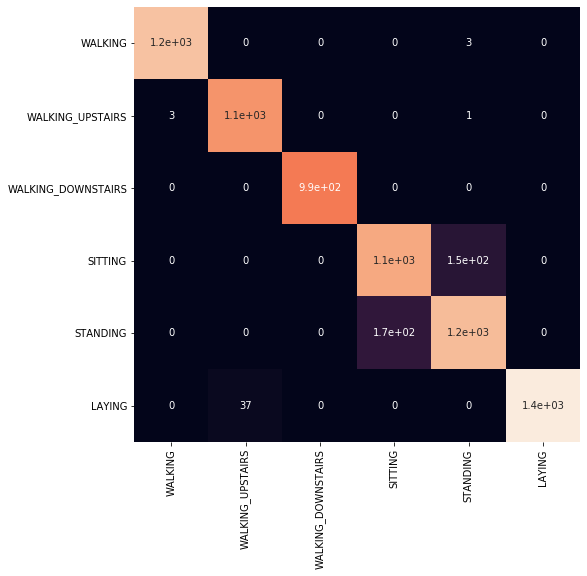

In [49]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_train, pred_labels), annot=True, cbar=False, xticklabels=label_reference['activity'], yticklabels=label_reference['activity'])

No se resolvió la confusión entre SITTING y STANDING.

Probemos con una red más compleja (por ahora sólo complejizando la salida). Como vimos algunos indicios de overfitting, incluiremos una capa de dropout para regularizar la red y contrastar los efectos de un modelo más complejo.

In [50]:
from keras.layers import Dropout

In [51]:
model = Sequential()
model.add(LSTM(100, input_shape=(128, 9)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 47,430
Trainable params: 47,430
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile('rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [53]:
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=30, validation_split=0.15, shuffle=True, verbose=1)

Train on 6249 samples, validate on 1103 samples
Epoch 1/30
6249/6249 [==============================] - 3s 538us/step - loss: 1.3534 - acc: 0.4311 - val_loss: 1.1831 - val_acc: 0.4687
Epoch 2/30
6249/6249 [==============================] - 3s 472us/step - loss: 1.1656 - acc: 0.4945 - val_loss: 1.1745 - val_acc: 0.4769
Epoch 3/30
6249/6249 [==============================] - 3s 467us/step - loss: 1.1117 - acc: 0.5207 - val_loss: 1.0959 - val_acc: 0.5340
Epoch 4/30
6249/6249 [==============================] - 3s 459us/step - loss: 1.0658 - acc: 0.5393 - val_loss: 1.0885 - val_acc: 0.4995
Epoch 5/30
6249/6249 [==============================] - 3s 458us/step - loss: 1.0359 - acc: 0.5639 - val_loss: 1.0518 - val_acc: 0.5413
Epoch 6/30
6249/6249 [==============================] - 3s 457us/step - loss: 0.9599 - acc: 0.5956 - val_loss: 0.9230 - val_acc: 0.6981
Epoch 7/30
6249/6249 [==============================] - 3s 456us/step - loss: 0.8464 - acc: 0.6769 - val_loss: 0.7802 - val_acc: 0.7335


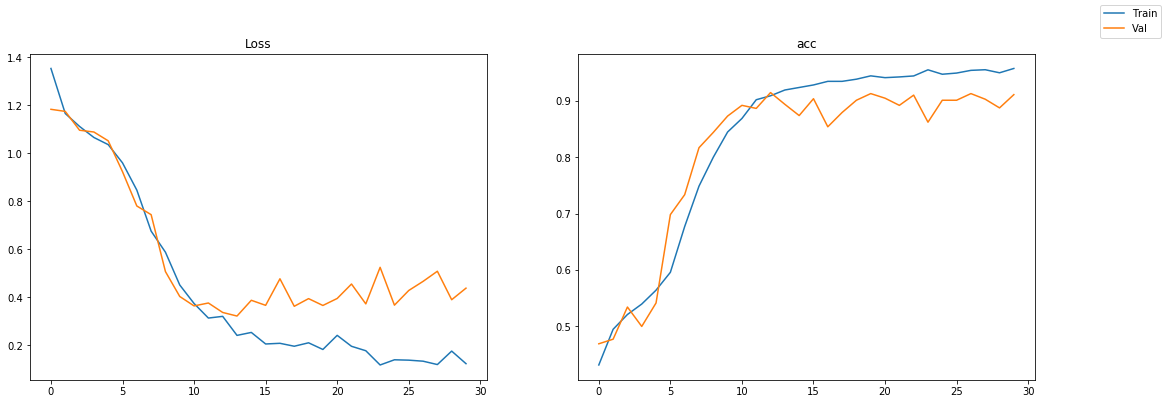

In [54]:
plot_history(history, 'acc')

In [55]:
pred = model.predict(X_train)

In [56]:
pred_labels = pred.argmax(axis=1)

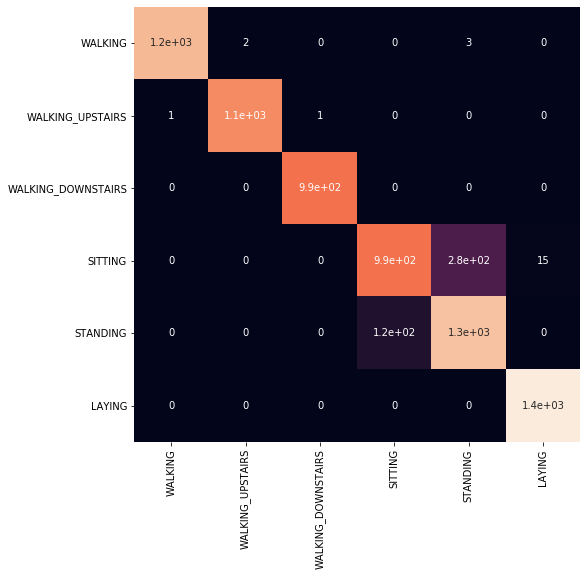

In [57]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_train, pred_labels), annot=True, cbar=False, xticklabels=label_reference['activity'], yticklabels=label_reference['activity'])

El problema persiste, por lo que sería conveniente revisar en detalle esas dos clases del dataset, ya que son las únicas que presentan problemas para diferenciarse entre sí.

### Evaluación sobre el set de testing

Procederemos a evaluar el modelo midiendo su performance sobre el set de testing.

In [58]:
data = []
filename = ['body_acc_{}_test.txt', 'body_gyro_{}_test.txt', 'total_acc_{}_test.txt']
axis = ['x', 'y', 'z']
path = 'UCI HAR Dataset'
for f in filename:
    for a in axis:
        full_path = os.path.join(path, 'test', 'Inertial Signals', f.format(a))
        data.append(pd.read_csv(full_path, header=None, delim_whitespace=True).values)

In [59]:
X_test = np.stack(data)

In [60]:
X_test.shape

(9, 2947, 128)

In [61]:
X_test = X_test.transpose(1,2,0)
X_test.shape

(2947, 128, 9)

Este set de muestras contiene el 30% restante que no fue utilizado para entrenar. Debemos normalizarlo con los mismos parámetros que el set de entrenamiento.

In [62]:
X_test = (X_test - X_min) / (X_max - X_min)

In [63]:
X_test = X_test * 2 - 1

In [64]:
X_test.max(axis=(0,1))

array([0.88760776, 0.82740561, 0.7065022 , 0.80596907, 0.61128416,
       0.79738647, 0.93623839, 0.94067576, 0.83705424])

In [65]:
X_test.min(axis=(0,1))

array([-0.74185447, -0.91880042, -0.78789886, -0.70706804, -0.51893674,
       -0.94542597, -0.85825197, -1.00438089, -0.79999261])

In [66]:
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, delim_whitespace=True)
y_test

,0
0,5
1,5
2,5
3,5
4,5
...,...
2942,2
2943,2
2944,2
2945,2


In [67]:
y_test.shape

(2947, 1)

In [68]:
y_test[0].value_counts()

6    537
5    532
1    496
4    491
2    471
3    420
Name: 0, dtype: int64

In [69]:
y_test = y_test - 1

In [70]:
y_test_cat = to_categorical(y_test.values)

In [71]:
y_test_cat.shape

(2947, 6)

In [72]:
y_test_cat

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [73]:
model.evaluate(X_test, y_test_cat)

2947/2947 [==============================] - 1s 398us/step


[0.3132793015260776, 0.9212758541107178]

Obtuvimos una métrica que iguala (o mejora, depende la corrida) el benchmark usando feature engineering (561 features) + SVM